In [124]:
# imports
import keras_tuner as kt
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from nnTrain import getSplitData
from selectionPlots import findAllFilesInPath

In [125]:
class HyperTuner(kt.HyperModel):
  def build(self, hp):
    model = Sequential()

    for i in range(hp.Int("num_layers", 1, 6)): # Variable number of hidden layers
      model.add(
        Dense(
          units = hp.Int(f"units_{i}", min_value = 4, max_value = 40, step = 2),
          activation = hp.Choice("activation", ["relu", "tanh", "elu"])
        )
      ) # Hidden layer

    if hp.Boolean("dropout"): # Possible dropout layer to prevent overfitting
      model.add(Dropout(rate = hp.Float("dropout_rate", min_value = 0.4, max_value = 0.9, step = 0.1)))

    model.add(Dense(1, activation = "sigmoid")) # Output layer

    learning_rate = hp.Float("lr", min_value = 1e-4, max_value = 1e-2, sampling = "log")

    # Compile the model
    model.compile(
      loss = "binary_crossentropy", optimizer = Adam(learning_rate = learning_rate), metrics = ["accuracy"]
    )

    return model

  def fit(self, hp, model, *args, **kwargs):
    return model.fit(
      *args,
      batch_size = hp.Int("batch_size", 32, 128, step = 32),
      **kwargs
    )

In [129]:
sampleNames = findAllFilesInPath("*.root", "nTupleGroups/")
nTupleSamples = dict.fromkeys(sampleNames, 0)
nTupleSamples["nTupleGroups/signalGroup.root"] = 1

# Tuple of variables to get from each file
variables = ["tauPtSum", "zMassSum", "metPt", "deltaRll", "deltaRtt", "deltaRttll", "deltaEtall", "deltaEtatt",
             "nJets", "deltaPhill", "deltaPhitt", "deltaPhilltt", "mmc"]

cut = "2lep"
X_train, X_test, y_train, y_test = getSplitData(nTupleSamples, variables, cut, 0)

In [130]:
# Create the tuner
tuner = kt.Hyperband(HyperTuner(),
                      objective = "val_accuracy",
                      max_epochs = 100,
                      factor = 3,
                      directory = "hyperTuning",
                      project_name = "hyperTuning" + cut,
                      overwrite = True)

stop_early = EarlyStopping(monitor = "val_loss", patience = 5, restore_best_weights = True, verbose = 1)

In [131]:
# 0.25*0.8 = 0.2 to get 20% of the data for validation
tuner.search(X_train, y_train, validation_split = 0.25, callbacks = [stop_early])

Trial 254 Complete [00h 00m 06s]
val_accuracy: 0.8347320556640625

Best val_accuracy So Far: 0.8347320556640625
Total elapsed time: 00h 11m 40s
INFO:tensorflow:Oracle triggered exit


In [1]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print("The hyperparameter search is complete (" + cut + "). The optimal number of layers was:", best_hps.get("num_layers"))

for i in range(best_hps.get("num_layers")):
  print("layer", i, ":", best_hps.get(f"units_{i}"), best_hps.get("activation"))

print("Learning rate:", best_hps.get("lr"))

print("Batch size:", best_hps.get("batch_size"))

print("Dropout:", best_hps.get("dropout"))
if best_hps.get("dropout"):
  print("Dropout rate:", best_hps.get("dropout_rate"))

NameError: name 'tuner' is not defined

In [122]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs = 50, validation_split = 0.25, callbacks = [stop_early])
print(len(history.history["accuracy"]))

Epoch 1/50
439/439 [==============================] - 1s 2ms/step - loss: 0.4721 - accuracy: 0.7868 - val_loss: 0.4355 - val_accuracy: 0.8094
Epoch 2/50
439/439 [==============================] - 1s 2ms/step - loss: 0.4163 - accuracy: 0.8214 - val_loss: 0.4097 - val_accuracy: 0.8246
Epoch 3/50
439/439 [==============================] - 1s 2ms/step - loss: 0.4026 - accuracy: 0.8271 - val_loss: 0.4024 - val_accuracy: 0.8250
Epoch 4/50
439/439 [==============================] - 1s 2ms/step - loss: 0.3980 - accuracy: 0.8298 - val_loss: 0.4031 - val_accuracy: 0.8257
Epoch 5/50
439/439 [==============================] - 1s 2ms/step - loss: 0.3958 - accuracy: 0.8298 - val_loss: 0.4024 - val_accuracy: 0.8293
Epoch 6/50
439/439 [==============================] - 1s 2ms/step - loss: 0.3937 - accuracy: 0.8311 - val_loss: 0.3992 - val_accuracy: 0.8263
Epoch 7/50
439/439 [==============================] - 1s 2ms/step - loss: 0.3919 - accuracy: 0.8308 - val_loss: 0.3997 - val_accuracy: 0.8332
Epoch 

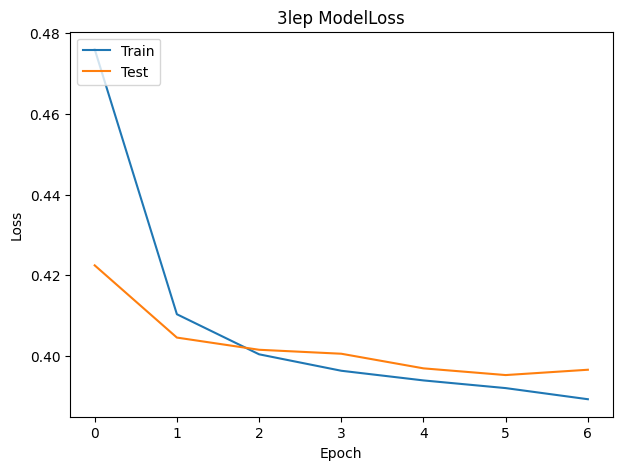

<Figure size 640x480 with 0 Axes>

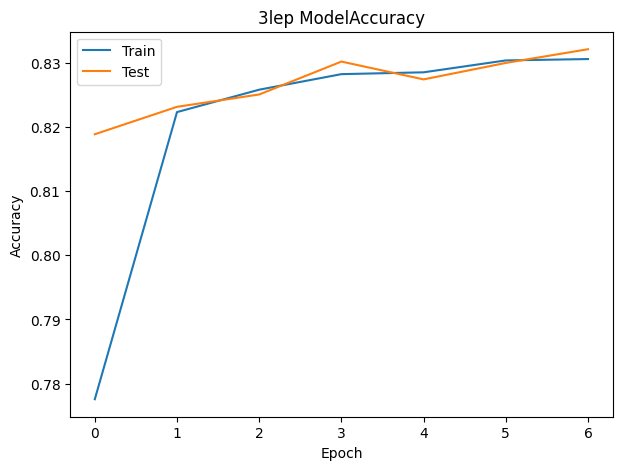

<Figure size 640x480 with 0 Axes>

In [116]:
# Plot the accuracy and loss per epoch
%matplotlib inline
import matplotlib.pyplot as plt
for i in ("loss", "accuracy"):
    plt.figure(figsize = (7, 5\))
    plt.plot(history.history[i])
    plt.plot(history.history["val_" + i])
    plt.title(cut + " Model" + i.capitalize())
    plt.ylabel(i.capitalize())
    plt.xlabel("Epoch")
    plt.legend(['Train', 'Test'], loc = 'upper left')
    plt.show()
    plt.clf()

In [105]:
# Save the model
model.save("nnModels/hyperTuned" + cut + ".h5")